In [1]:
import numpy as np
import csv
from tqdm import tqdm
from sklearn.utils import shuffle
import nltk
import re
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, Convolution1D, MaxPooling1D, MaxPooling2D, Convolution2D, LSTM, Reshape, Dropout, Flatten
from keras import regularizers 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,f1_score
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#declare path
path_to_project = '/content/gdrive/My Drive/ESTR project AI/OLIDv1.0/'
path_to_data = path_to_project + 'olid-training-v1.0.tsv'

In [0]:
#0 - Not offensive
#1 - Offensive untargeted
#2 - Offensive targeted indiviualds
#3 - Offensive targeted groups 
#4 - Offensive targeted others
def get_label(labels):
  answer = 0
  if labels[1] == 'UNT':
    answer = 1
  if labels[2] == 'IND':
    answer = 2
  if labels[2] == 'GRP':
    answer = 3
  if labels[2] == 'OTH':
    answer = 4
  return answer

def convert(label, sub_task):
  if sub_task == 'a':
    return int(label > 0)
  if sub_task == 'b':
    return int(label > 1)
  return label - 2

def prepare_data(path,sub_task):
  data=[]
  labels=[]
  with open(path,encoding='utf8') as file:
    for i,line in enumerate(csv.reader(file,delimiter='\t')):
      if i == 0:
        continue
      x = get_label(line[-3:])
      if x > 1:
        data.append(line[1])
        labels.append(convert(x,sub_task))
  return data,labels  

def get_test_label(label,sub_task):
  answer = 0
  if sub_task == 'a':
    if label == 'OFF':
      answer = 1
  if sub_task == 'b':
    if label == 'TIN':
      answer = 1
  if sub_task == 'c':
    if label == 'GRP':
      answer = 1
    if label == 'OTH':
      answer = 2
  return answer
def get_test_data(sub_task):
  data=[]
  labels=[]
  path_labels = path_to_project + 'labels-level' + sub_task + '.csv'
  path_data = path_to_project + 'testset-level' + sub_task + '.tsv'
  with open(path_data,encoding='utf8') as file:
    for i,line in enumerate(csv.reader(file,delimiter='\t')):
      if i == 0:
        continue
      data.append(line[1])
  with open(path_labels,encoding='utf8') as file:
    for line in csv.reader(file):
      labels.append(get_test_label(line[1],sub_task))
      #labels.append(line[1])
  return data,labels

In [5]:
#preprocessing dependencies
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#preprocessing
def tokenize(data):
  answer = []
  for text in data:
    answer.append(nltk.word_tokenize(text.lower()))
  return answer

def stop_words(data):
  answer = []
  bad_words = set(nltk.corpus.stopwords.words('english'))
  for text in data:
    answer.append([x for x in text if not x in bad_words and not re.match(r"[^a-zA-Z\d\s]+", x) and x != 'user'])
  return answer

def get_tag(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
  return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)
  
def lemmatize(data):
  answer = []      
  lemmatizer = nltk.stem.WordNetLemmatizer()
  for text in data:
    answer.append([lemmatizer.lemmatize(x, pos=get_tag(x)) for x in text])
  return answer
  
#Vectorization
def count_vectorizer_len(data):
  vectorizer = CountVectorizer()
  converted_data = [' '.join(x) for x in data]
  vectorizer.fit(converted_data)
  return len(vectorizer.vocabulary_.keys())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
#preparing data to be compatibel with Neural networks
def do_one_hot(data):
  encoder = OneHotEncoder();
  return encoder.fit_transform(np.array(data).reshape(-1,1)).toarray()
def do_input_proc(data, len, longest_seq):
  converted_data = [keras.preprocessing.text.one_hot(' '.join(x), len) for x in data]
  return keras.preprocessing.sequence.pad_sequences(converted_data, maxlen=longest_seq, padding='post')
def get_max_len(data):
  answer = 0
  for x in data:
    answer = max(answer, len(x))
  return answer

In [0]:
def plot_confusion(data, labels, model, classes=3):
  predicted_labels = model.predict(data, batch_size=64)
  mtx = np.zeros(shape=(classes,classes))
  for i in range(0,len(predicted_labels)):
    actual_label = np.argmax(labels[i])
    predicted_label = np.argmax(predicted_labels[i])
    mtx[actual_label,predicted_label] += 1
  plt.imshow(mtx,cmap=plt.cm.ocean_r)
  plt.title('Confusion matrix')
  plt.colorbar()
  marks = [x for x in ['INT', 'GRP', 'OTH']]
  plt.xlabel('Predicted Label')
  plt.xticks(np.arange(classes), marks)
  plt.ylabel('True Label')
  plt.yticks(np.arange(classes), marks)
  plt.tight_layout()
  for (i, j), z in np.ndenumerate(mtx):
    plt.text(j, i, int(z), ha='center', va='center')
  plt.show()
def do_analysis(test_data, test_labels, model):
  predicted_labels = model.predict(test_data, batch_size=64)
  y_true = np.argmax(test_labels, axis = 1)
  y_pred = np.argmax(predicted_labels, axis = 1)
  print(classification_report(y_true, y_pred))
 # print(f1_score(y_true, y_pred))
  plot_confusion(test_data, test_labels, model, 3)

In [8]:
data,labels = prepare_data(path_to_data,'c')
test_data,test_labels = get_test_data('c')
data = lemmatize(stop_words(tokenize(data)))
test_data = lemmatize(stop_words(tokenize(test_data)))
vocab_length = count_vectorizer_len(data)
longest_seq = max(get_max_len(data),get_max_len(test_data))
#convert data to work with NN
train_data, val_data, train_labels, val_labels = train_test_split(np.array(data),labels, test_size=0.35,stratify=labels)
train_labels = do_one_hot(train_labels)
val_labels = do_one_hot(val_labels)
test_labels = do_one_hot(test_labels)
train_data = do_input_proc(train_data, vocab_length, longest_seq)
val_data = do_input_proc(val_data, vocab_length, longest_seq)
test_data = do_input_proc(test_data, vocab_length, longest_seq)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [10]:
# lstm model
lstm_complex = Sequential()
lstm_complex.add(Embedding(vocab_length, 30, input_length=longest_seq))
lstm_complex.add(LSTM(100))
lstm_complex.add(Dense(longest_seq, activation='relu', W_regularizer=regularizers.l2(0.90)))
lstm_complex.add(Dense(train_labels.shape[1], activation='softmax'))
lstm_complex.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
lstm_complex.summary()
early_stopping = EarlyStopping(monitor='val_acc', patience=5)






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 30)            236820    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               52400     
_________________________________________________________________
dense_1 (Dense)              (None, 41)                4141      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 126       
Total params: 293,487
Trainable params: 293,487
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(41, activation="relu", kernel_regularizer=<keras.reg...)`
  after removing the cwd from sys.path.


In [12]:
lstm_complex.fit(train_data, train_labels, batch_size=64,epochs=5,verbose=1,validation_data=(val_data,val_labels),callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2519 samples, validate on 1357 samples
Epoch 1/5





2519/2519 [==============================] - 8s 3ms/step - loss: 39.8689 - acc: 0.6209 - val_loss: 28.4361 - val_acc: 0.6212
Epoch 2/5
2519/2519 [==============================] - 3s 1ms/step - loss: 21.2353 - acc: 0.6209 - val_loss: 14.8935 - val_acc: 0.6212
Epoch 3/5
2519/2519 [==============================] - 3s 1ms/step - loss: 10.9664 - acc: 0.6673 - val_loss: 7.7323 - val_acc: 0.5748
Epoch 4/5
2519/2519 [==============================] - 3s 1ms/step - loss: 5.5464 - acc: 0.7523 - val_loss: 4.0311 - val_acc: 0.6618
Epoch 5/5
2519/2519 [==============================] - 3s 1ms/step - loss: 2.8232 - acc: 0.7860 - val_loss: 2.3082 - val_acc: 0.6227


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.65      0.80      0.72       100
           1       0.61      0.71      0.65        78
           2       0.00      0.00      0.00        35

    accuracy                           0.63       213
   macro avg       0.42      0.50      0.46       213
weighted avg       0.53      0.63      0.58       213



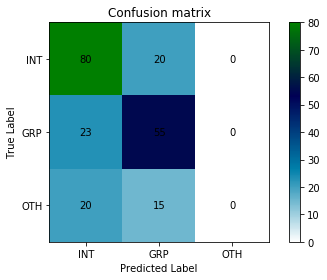

In [15]:
do_analysis(test_data, test_labels, lstm_complex)

In [18]:
# lstm model
lstm1 = Sequential()
lstm1.add(Embedding(vocab_length, 30, input_length=longest_seq))
lstm1.add(Dropout(0.5))
lstm1.add(LSTM(100))
#lstm1.add(Dense(longest_seq, activation='relu', W_regularizer=regularizers.l2(0.90))) , W_regularizer=regularizers.l2(0.1))
lstm1.add(Dense(train_labels.shape[1], activation='sigmoid'))
lstm1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
lstm1.summary()
early_stopping = EarlyStopping(monitor='val_acc', patience=2)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 30)            236820    
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               52400     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 289,523
Trainable params: 289,523
Non-trainable params: 0
_________________________________________________________________


In [0]:
class_weights = class_weights = class_weight.compute_class_weight('balanced', np.unique(labels), labels)

In [20]:
lstm1.fit(train_data, train_labels, batch_size=30,epochs=10,verbose=1,validation_data=(val_data,val_labels),class_weight=class_weights,callbacks=[early_stopping])

Train on 2519 samples, validate on 1357 samples
Epoch 1/10
2519/2519 [==============================] - 7s 3ms/step - loss: 0.9198 - acc: 0.6121 - val_loss: 0.8866 - val_acc: 0.6212
Epoch 2/10
2519/2519 [==============================] - 6s 2ms/step - loss: 0.8881 - acc: 0.6209 - val_loss: 0.8855 - val_acc: 0.6212
Epoch 3/10
2519/2519 [==============================] - 6s 2ms/step - loss: 0.8863 - acc: 0.6209 - val_loss: 0.8889 - val_acc: 0.6212


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.47      1.00      0.64       100
           1       0.00      0.00      0.00        78
           2       0.00      0.00      0.00        35

    accuracy                           0.47       213
   macro avg       0.16      0.33      0.21       213
weighted avg       0.22      0.47      0.30       213



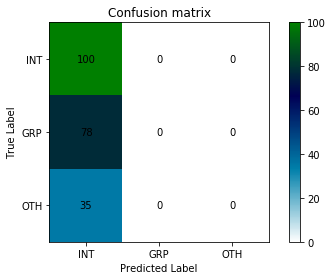

In [21]:
do_analysis(test_data, test_labels, lstm1)

In [31]:
cnn = Sequential()
cnn.add(Embedding(vocab_length, 30, input_length=longest_seq))
cnn.add(Reshape((30,longest_seq,1)))
cnn.add(Convolution2D(32,(1,5),activation="relu"))
cnn.add(Dropout(0.9))
cnn.add(Convolution2D(16,(2,3),activation="relu"))
cnn.add(Dropout(0.8))
cnn.add(Convolution2D(16,(2,2),activation="relu"))
cnn.add(Dropout(0.7))
cnn.add(Flatten())
cnn.add(Dense(train_labels.shape[1],activation='sigmoid'))
cnn.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 30)            236820    
_________________________________________________________________
reshape_4 (Reshape)          (None, 30, 41, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 37, 32)        192       
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 35, 16)        3088      
_________________________________________________________________
dropout_12 (Dropout)         (None, 29, 35, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 34, 16)       

In [32]:
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
cnn.fit(train_data, train_labels, batch_size=64,epochs=15,verbose=1,validation_data=(test_data,test_labels),callbacks=[early_stopping],class_weight=class_weights)

Train on 2519 samples, validate on 213 samples
Epoch 1/15
2519/2519 [==============================] - 1s 500us/step - loss: 0.9105 - acc: 0.6133 - val_loss: 1.0518 - val_acc: 0.4695
Epoch 2/15
2519/2519 [==============================] - 0s 104us/step - loss: 0.8841 - acc: 0.6209 - val_loss: 1.0411 - val_acc: 0.4695
Epoch 3/15
2519/2519 [==============================] - 0s 106us/step - loss: 0.8780 - acc: 0.6209 - val_loss: 1.0547 - val_acc: 0.4695
Epoch 4/15
2519/2519 [==============================] - 0s 96us/step - loss: 0.8691 - acc: 0.6209 - val_loss: 1.0582 - val_acc: 0.4695
Epoch 5/15
2519/2519 [==============================] - 0s 100us/step - loss: 0.8427 - acc: 0.6237 - val_loss: 1.0643 - val_acc: 0.5305
Epoch 6/15
2519/2519 [==============================] - 0s 97us/step - loss: 0.7451 - acc: 0.6908 - val_loss: 1.0357 - val_acc: 0.5775
Epoch 7/15
2519/2519 [==============================] - 0s 104us/step - loss: 0.6146 - acc: 0.7511 - val_loss: 0.9888 - val_acc: 0.5540
Epo

              precision    recall  f1-score   support

           0       0.54      0.75      0.63       100
           1       0.54      0.49      0.51        78
           2       0.00      0.00      0.00        35

    accuracy                           0.53       213
   macro avg       0.36      0.41      0.38       213
weighted avg       0.45      0.53      0.48       213



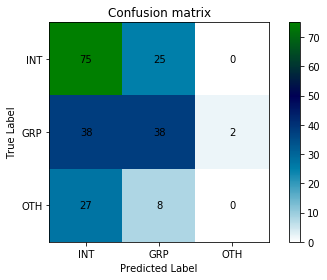

In [33]:
do_analysis(test_data, test_labels, cnn)